In [1]:
# step1_imports_and_constants.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from datetime import timezone
import math

In [ ]:
# --- Configuration (same defaults as MATLAB script) ---
CSV_FILE = 'C:/Medical Waste/Taraz_rotes.csv'
GAP_MINUTES_NEW_TRIP = 15
MIN_CLUSTER_POINTS = 3
STATIONARY_SPEED_KMH = 1.0
STATIONARY_STEPDIST_M = 5.0

In [3]:
# step1_load_df.py
# Запустите этот блок первым — он создаёт DataFrame `df`.

df = pd.read_csv(CSV_FILE)
# Убедимся, что данные загружены
print("Загружено строк:", len(df))
print("Столбцы:", list(df.columns))
# При желании показать первые 5 строк:
print(df.head())


Загружено строк: 1205
Столбцы: ['latitude', 'longitude', '_id', 'deviceId', 'altitude', 'speed', 'course', 'battery', 'isCollecting', 'timestamp', 'createdAt', 'updatedAt', '__v']
   latitude  longitude                       _id    deviceId  altitude  \
0       NaN        NaN                       NaN         NaN       NaN   
1  51.13068   71.45750  d0a7611aae4b8e359a387953  DRIVER-001     370.1   
2  51.13069   71.45748  a28de44ce4ebe47a7c6e14f1  DRIVER-001     368.0   
3  51.13066   71.45741  9abe4ca498ac36b5eebb5faf  DRIVER-001     363.6   
4  51.13060   71.45732  098b423d023b384cf36156cb  DRIVER-001     347.8   

     speed  course  battery isCollecting                 timestamp  \
0      NaN     NaN      NaN          NaN                       NaN   
1  8.36689  314.78    100.0         True  2025-10-04T08:23:00.000Z   
2  9.47843  233.35    100.0         True  2025-10-04T08:23:05.000Z   
3  7.99471  226.00    100.0         True  2025-10-04T08:23:10.000Z   
4  8.69351  272.87    100

In [4]:
# step2_normalize_columns_fixed.py
# Требует: df (из Шага 1) уже загружен
# Создаёт DataFrame 'data' с едиными колонками:
# latitude, longitude, timestamp(UTC), deviceId, speed_kmh

import pandas as pd
import numpy as np

# --- вспомогательная функция для безопасного перевода времени в UTC ---
def ensure_utc(series):
    """Безопасно приводит временные метки к UTC независимо от формата."""
    ts = pd.to_datetime(series, errors="coerce")
    # если нет tz — локализуем, если уже есть — конвертируем
    if getattr(ts.dt, "tz", None) is None:
        ts = ts.dt.tz_localize("UTC")
    else:
        ts = ts.dt.tz_convert("UTC")
    return ts

# --- Поиск столбцов по типичным именам ---
cols_lower = {c.lower(): c for c in df.columns}

lat_keys = ["latitude", "lat"]
lon_keys = ["longitude", "lon", "lng"]
ts_keys  = ["timestamp", "createdat", "updatedat", "time", "datetime"]
spd_keys = ["speed", "velocity"]
dev_keys = ["deviceid", "device", "device_id", "dev_id"]

def find_key(candidates):
    for k in candidates:
        if k in cols_lower:
            return cols_lower[k]
    return None

lat_col = find_key(lat_keys)
lon_col = find_key(lon_keys)
ts_col  = find_key(ts_keys)
spd_col = find_key(spd_keys)
dev_col = find_key(dev_keys)

if lat_col is None or lon_col is None or ts_col is None:
    raise ValueError("CSV должен содержать координаты и время (latitude, longitude, timestamp).")

# --- Формируем нормализованный DataFrame ---
data = pd.DataFrame({
    "latitude": pd.to_numeric(df[lat_col], errors="coerce"),
    "longitude": pd.to_numeric(df[lon_col], errors="coerce"),
})

# --- Преобразование времени ---
data["timestamp"] = ensure_utc(df[ts_col])

# --- Обработка deviceId ---
if dev_col:
    data["deviceId"] = df[dev_col].astype(str).replace({"nan": "DEVICE-1"}).fillna("DEVICE-1")
else:
    data["deviceId"] = "DEVICE-1"

# --- Скорость: приведение к км/ч (если median < 20, значит м/с) ---
if spd_col:
    spd = pd.to_numeric(df[spd_col], errors="coerce")
    if np.nanmedian(spd) < 20:
        spd = spd * 3.6
    data["speed_kmh"] = spd
else:
    data["speed_kmh"] = np.nan

# --- Упорядочим и сбросим индекс ---
data = data.sort_values(["deviceId", "timestamp"]).reset_index(drop=True)

print("✅ DataFrame 'data' успешно создан")
print("Столбцы:", list(data.columns))
print("Пример данных:")
print(data.head())


✅ DataFrame 'data' успешно создан
Столбцы: ['latitude', 'longitude', 'timestamp', 'deviceId', 'speed_kmh']
Пример данных:
   latitude  longitude timestamp  deviceId  speed_kmh
0       NaN        NaN       NaT  DEVICE-1        NaN
1       NaN        NaN       NaT  DEVICE-1        NaN
2       NaN        NaN       NaT  DEVICE-1        NaN
3       NaN        NaN       NaT  DEVICE-1        NaN
4       NaN        NaN       NaT  DEVICE-1        NaN


In [5]:
# step3_haversine.py
def haversine_m(lat1, lon1, lat2, lon2):
    """
    Векторный haversine (метры). Поддерживает numpy-массивы/скаляры.
    """
    R = 6371000.0
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


In [6]:
# step4_assign_trips.py
# Требует data (шаг 2) и константу GAP_MINUTES_NEW_TRIP

data["dt_s"] = np.nan
data["trip_id"] = np.nan

trip_counter = 0
for device in data["deviceId"].unique():
    idx = data.index[data["deviceId"] == device].tolist()
    if not idx:
        continue
    ts = data.loc[idx, "timestamp"].values
    # вычисляем dt
    dt = np.empty(len(idx))
    dt[0] = np.nan
    for i in range(1, len(idx)):
        td = ts[i] - ts[i-1]
        dt[i] = td / np.timedelta64(1, "s")
    data.loc[idx, "dt_s"] = dt
    new_trip = np.isnan(dt) | (dt > GAP_MINUTES_NEW_TRIP * 60)
    grp = np.cumsum(new_trip)
    trip_ids = grp + trip_counter
    data.loc[idx, "trip_id"] = trip_ids
    trip_counter = trip_counter + int(grp.max() if len(grp) else 0)

data["trip_id"] = data["trip_id"].astype(int)
print("Trip segmentation выполнена. Пример:")
print(data[["deviceId","timestamp","dt_s","trip_id"]].head(12))


Trip segmentation выполнена. Пример:
      deviceId                 timestamp  dt_s  trip_id
0     DEVICE-1                       NaT   NaN        1
1     DEVICE-1                       NaT   NaN        2
2     DEVICE-1                       NaT   NaN        3
3     DEVICE-1                       NaT   NaN        4
4     DEVICE-1                       NaT   NaN        5
5   DRIVER-001 2025-10-04 08:23:00+00:00   NaN        6
6   DRIVER-001 2025-10-04 08:23:05+00:00   5.0        6
7   DRIVER-001 2025-10-04 08:23:10+00:00   5.0        6
8   DRIVER-001 2025-10-04 08:23:15+00:00   5.0        6
9   DRIVER-001 2025-10-04 08:23:20+00:00   5.0        6
10  DRIVER-001 2025-10-04 08:23:25+00:00   5.0        6
11  DRIVER-001 2025-10-04 08:23:30+00:00   5.0        6


In [7]:
# step5_stepdist_and_speed.py
# Требует data (шаг 4) и функцию haversine_m

data["stepDist_m"] = np.nan
n = len(data)
for i in range(1, n):
    if data.at[i, "trip_id"] == data.at[i-1, "trip_id"]:
        lat1, lon1 = data.at[i-1, "latitude"], data.at[i-1, "longitude"]
        lat2, lon2 = data.at[i, "latitude"], data.at[i, "longitude"]
        data.at[i, "stepDist_m"] = haversine_m(lat1, lon1, lat2, lon2)

# Если все скорости NaN -> вывести
if data["speed_kmh"].isna().all():
    with np.errstate(divide="ignore", invalid="ignore"):
        inferred = (data["stepDist_m"] / data["dt_s"]) * 3.6
    data["speed_kmh"] = inferred

print("Вычислены stepDist_m и (при необходимости) speed_kmh.")
print(data[["timestamp","stepDist_m","dt_s","speed_kmh"]].head(12))


Вычислены stepDist_m и (при необходимости) speed_kmh.
                   timestamp  stepDist_m  dt_s  speed_kmh
0                        NaT         NaN   NaN        NaN
1                        NaT         NaN   NaN        NaN
2                        NaT         NaN   NaN        NaN
3                        NaT         NaN   NaN        NaN
4                        NaT         NaN   NaN        NaN
5  2025-10-04 08:23:00+00:00         NaN   NaN  30.120804
6  2025-10-04 08:23:05+00:00    1.784412   5.0  34.122348
7  2025-10-04 08:23:10+00:00    5.914996   5.0  28.780956
8  2025-10-04 08:23:15+00:00    9.162558   5.0  31.296636
9  2025-10-04 08:23:20+00:00    3.004537   5.0  21.760380
10 2025-10-04 08:23:25+00:00   13.048692   5.0  25.584444
11 2025-10-04 08:23:30+00:00    7.137667   5.0  18.939744


In [8]:
# step6_detect_stationary_runs.py
# Требует data (шаг 5) и константы MIN_CLUSTER_POINTS, STATIONARY_SPEED_KMH, STATIONARY_STEPDIST_M

data["is_stationary_point"] = ((data["speed_kmh"] < STATIONARY_SPEED_KMH) | (data["stepDist_m"] <= STATIONARY_STEPDIST_M)).fillna(False)
data["stationary_run_id"] = -1

run_id = 0
grouped = data.groupby(["deviceId", "trip_id"], sort=False)
for (_, _), group_idx in grouped.groups.items():
    idxs = list(group_idx)
    run_start = None
    run_count = 0
    for k in idxs:
        if data.at[k, "is_stationary_point"]:
            if run_start is None:
                run_start = k
                run_count = 1
            else:
                run_count += 1
        else:
            if run_start is not None and run_count >= MIN_CLUSTER_POINTS:
                run_id += 1
                data.loc[range(run_start, run_start + run_count), "stationary_run_id"] = run_id
            run_start = None
            run_count = 0
    # конец группы — финализация
    if run_start is not None and run_count >= MIN_CLUSTER_POINTS:
        run_id += 1
        data.loc[range(run_start, run_start + run_count), "stationary_run_id"] = run_id

print("Обнаружены стационарные кластеры. Пример строк с метками:")
print(data.loc[data["stationary_run_id"] >= 0, ["timestamp","latitude","longitude","stationary_run_id"]].head(12))


Обнаружены стационарные кластеры. Пример строк с метками:
                    timestamp  latitude  longitude  stationary_run_id
488 2025-10-04 15:47:15+00:00  51.13074   71.45760                  1
489 2025-10-04 15:47:20+00:00  51.13073   71.45761                  1
490 2025-10-04 15:47:25+00:00  51.13076   71.45766                  1
496 2025-10-04 15:47:55+00:00  51.13093   71.45792                  2
497 2025-10-04 15:48:00+00:00  51.13095   71.45795                  2
498 2025-10-04 15:48:05+00:00  51.13094   71.45795                  2
499 2025-10-04 15:48:10+00:00  51.13096   71.45799                  2
514 2025-10-04 15:49:25+00:00  51.13115   71.45840                  3
515 2025-10-04 15:49:30+00:00  51.13116   71.45843                  3
516 2025-10-04 15:49:35+00:00  51.13117   71.45846                  3
530 2025-10-04 15:50:45+00:00  51.13148   71.45898                  4
531 2025-10-04 15:50:50+00:00  51.13148   71.45899                  4


In [9]:
# step6_detect_stationary_runs.py
# Требует data (шаг 5) и константы MIN_CLUSTER_POINTS, STATIONARY_SPEED_KMH, STATIONARY_STEPDIST_M

data["is_stationary_point"] = ((data["speed_kmh"] < STATIONARY_SPEED_KMH) | (data["stepDist_m"] <= STATIONARY_STEPDIST_M)).fillna(False)
data["stationary_run_id"] = -1

run_id = 0
grouped = data.groupby(["deviceId", "trip_id"], sort=False)
for (_, _), group_idx in grouped.groups.items():
    idxs = list(group_idx)
    run_start = None
    run_count = 0
    for k in idxs:
        if data.at[k, "is_stationary_point"]:
            if run_start is None:
                run_start = k
                run_count = 1
            else:
                run_count += 1
        else:
            if run_start is not None and run_count >= MIN_CLUSTER_POINTS:
                run_id += 1
                data.loc[range(run_start, run_start + run_count), "stationary_run_id"] = run_id
            run_start = None
            run_count = 0
    # конец группы — финализация
    if run_start is not None and run_count >= MIN_CLUSTER_POINTS:
        run_id += 1
        data.loc[range(run_start, run_start + run_count), "stationary_run_id"] = run_id

print("Обнаружены стационарные кластеры. Пример строк с метками:")
print(data.loc[data["stationary_run_id"] >= 0, ["timestamp","latitude","longitude","stationary_run_id"]].head(12))


Обнаружены стационарные кластеры. Пример строк с метками:
                    timestamp  latitude  longitude  stationary_run_id
488 2025-10-04 15:47:15+00:00  51.13074   71.45760                  1
489 2025-10-04 15:47:20+00:00  51.13073   71.45761                  1
490 2025-10-04 15:47:25+00:00  51.13076   71.45766                  1
496 2025-10-04 15:47:55+00:00  51.13093   71.45792                  2
497 2025-10-04 15:48:00+00:00  51.13095   71.45795                  2
498 2025-10-04 15:48:05+00:00  51.13094   71.45795                  2
499 2025-10-04 15:48:10+00:00  51.13096   71.45799                  2
514 2025-10-04 15:49:25+00:00  51.13115   71.45840                  3
515 2025-10-04 15:49:30+00:00  51.13116   71.45843                  3
516 2025-10-04 15:49:35+00:00  51.13117   71.45846                  3
530 2025-10-04 15:50:45+00:00  51.13148   71.45898                  4
531 2025-10-04 15:50:50+00:00  51.13148   71.45899                  4


In [10]:
# step7_cluster_stats.py
# Требует data (шаг 6) и функцию haversine_m

valid = data["stationary_run_id"] >= 0
if not valid.any():
    raise RuntimeError("Кластеры не найдены. Попробуйте ослабить пороги или уменьшить MIN_CLUSTER_POINTS.")

cluster_stats = []
err_all = []

for cid, grp in data[valid].groupby("stationary_run_id"):
    lat = grp["latitude"].to_numpy()
    lon = grp["longitude"].to_numpy()
    lat0 = lat.mean()
    lon0 = lon.mean()
    errs = haversine_m(lat0, lon0, lat, lon)
    err_all.extend(errs.tolist())
    cs = {
        "cluster_id": int(cid),
        "trip_id": int(grp["trip_id"].mode().iloc[0]),
        "deviceId": grp["deviceId"].iloc[0],
        "point_count": int(len(grp)),
        "mean_lat": float(lat0),
        "mean_lng": float(lon0),
        "mean_error": float(np.mean(errs)),
        "max_error": float(np.max(errs)),
        "std_dev": float(np.std(errs, ddof=0)),
    }
    cluster_stats.append(cs)

err_all = np.array(err_all)
mean_error = float(err_all.mean())
max_error = float(err_all.max())
std_dev_error = float(err_all.std(ddof=0))
pct_levels = [50, 68, 95, 99]
pct_vals = np.percentile(err_all, pct_levels).tolist()
within_1sigma = float((err_all <= (mean_error + std_dev_error)).mean() * 100)
within_2sigma = float((err_all <= (mean_error + 2 * std_dev_error)).mean() * 100)
within_3sigma = float((err_all <= (mean_error + 3 * std_dev_error)).mean() * 100)

# Печать краткой сводки
print("\nGPS Error Statistics across ALL trips (multi-iteration):")
print(f"  Mean: {mean_error:.2f} m | Max: {max_error:.2f} m | Std: {std_dev_error:.2f} m")
print("  Percentiles (CEP50, P68, P95, P99):", dict(zip(pct_levels, [f"{v:.2f}m" for v in pct_vals])))
print(f"\nGaussian Test (empirical within mean + kσ): 1σ {within_1sigma:.1f}% | 2σ {within_2sigma:.1f}% | 3σ {within_3sigma:.1f}%")

# Печать деталей кластеров
print("\nCluster Details:")
print("{:<8} {:<8} {:<12} {:<12} {:<8} {:<10} {:<10}".format("Cluster","Trip","Mean Lat","Mean Lng","Points","MeanErr","MaxErr"))
for cs in cluster_stats:
    print("{cluster_id:<8d} {trip_id:<8d} {mean_lat:<12.6f} {mean_lng:<12.6f} {point_count:<8d} {mean_error:<10.2f} {max_error:<10.2f}".format(**cs))



GPS Error Statistics across ALL trips (multi-iteration):
  Mean: 2.18 m | Max: 6.84 m | Std: 1.71 m
  Percentiles (CEP50, P68, P95, P99): {50: '1.75m', 68: '2.77m', 95: '6.22m', 99: '6.76m'}

Gaussian Test (empirical within mean + kσ): 1σ 86.0% | 2σ 93.0% | 3σ 100.0%

Cluster Details:
Cluster  Trip     Mean Lat     Mean Lng     Points   MeanErr    MaxErr    
1        7        51.130743    71.457623    3        2.19       3.16      
2        7        51.130945    71.457952    4        1.77       3.10      
3        7        51.131160    71.458430    3        1.58       2.37      
4        7        51.131480    71.458997    4        0.87       1.57      
5        7        51.131600    71.459253    3        1.52       2.17      
6        7        51.131767    71.459560    3        0.73       1.02      
7        7        51.131960    71.459953    3        2.19       3.22      
8        7        51.132993    71.461323    3        1.49       2.20      
9        7        51.134197    71.4629

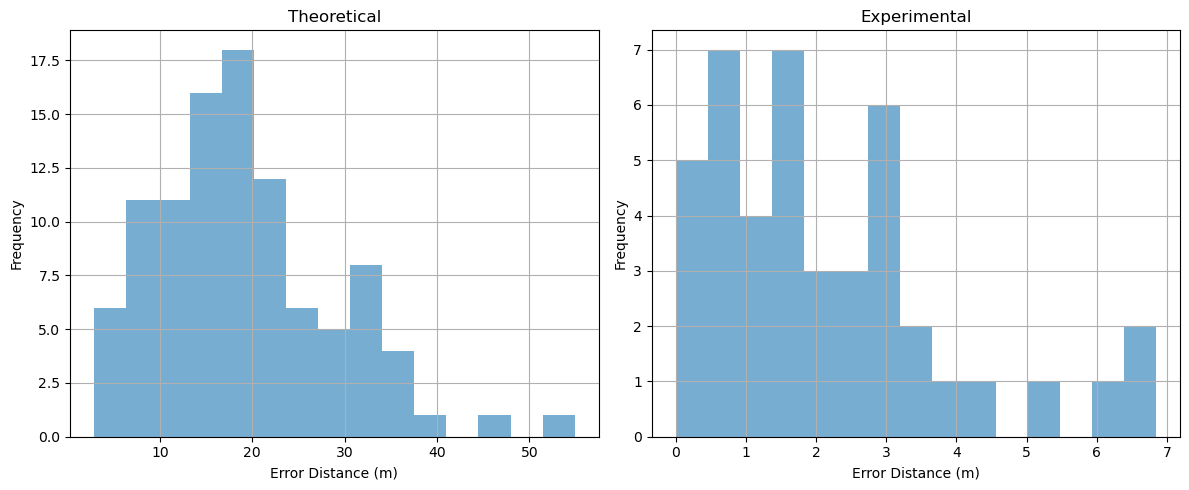

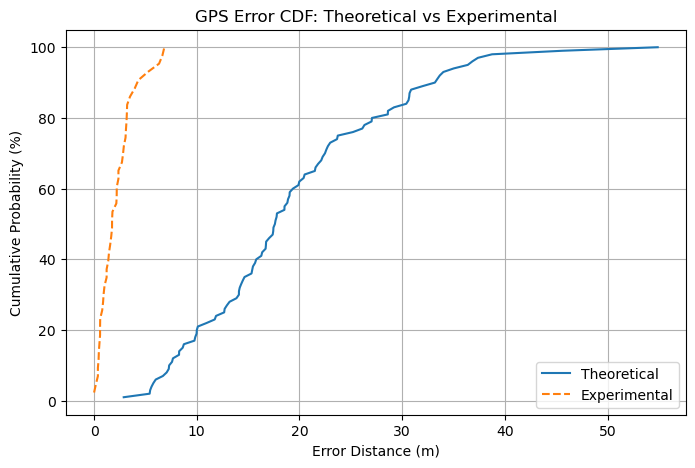

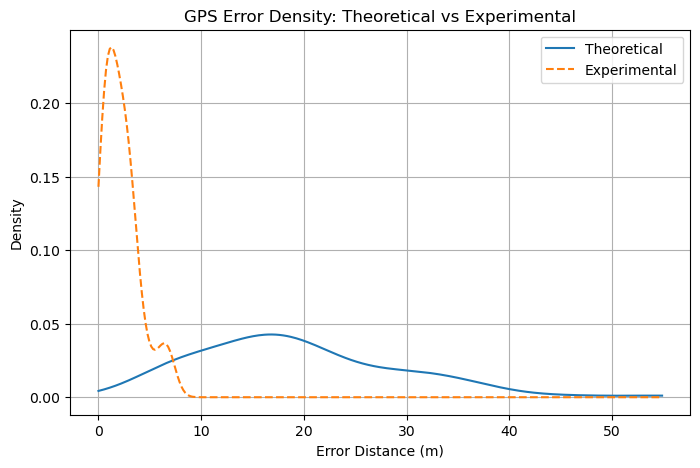

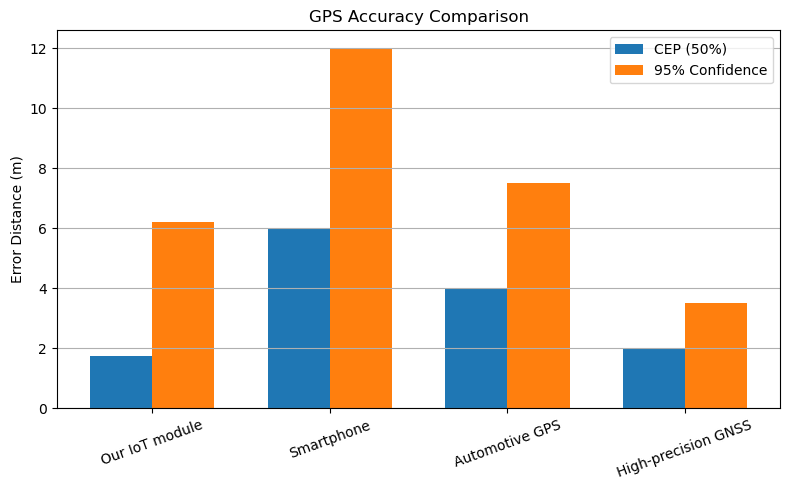

In [11]:
# step8_theoretical_and_plots.py
# Требует cluster_stats и err_all из Шага 7

def generate_theoretical_errors(n_points=100, sigma_urban=15.0):
    true_path = np.column_stack([np.linspace(0, 1000, n_points), np.zeros(n_points)])
    noise = np.random.normal(scale=sigma_urban, size=(n_points, 2))
    measured = true_path + noise
    errors = np.sqrt(np.sum((measured - true_path) ** 2, axis=1))
    return errors

theo_errors = generate_theoretical_errors()
exp_errors = err_all  # из предыдущего шага

# Гистограммы
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(theo_errors, bins=15, alpha=0.6)
plt.title("Theoretical")
plt.xlabel("Error Distance (m)")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(exp_errors, bins=15, alpha=0.6)
plt.title("Experimental")
plt.xlabel("Error Distance (m)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# CDF
sorted_theo = np.sort(theo_errors)
sorted_exp = np.sort(exp_errors)
cdf_theo = np.linspace(0,100,len(sorted_theo),endpoint=False) + 100/len(sorted_theo)
cdf_exp = np.linspace(0,100,len(sorted_exp),endpoint=False) + 100/len(sorted_exp)

plt.figure(figsize=(8,5))
plt.plot(sorted_theo, cdf_theo, label="Theoretical")
plt.plot(sorted_exp, cdf_exp, linestyle="--", label="Experimental")
plt.xlabel("Error Distance (m)")
plt.ylabel("Cumulative Probability (%)")
plt.title("GPS Error CDF: Theoretical vs Experimental")
plt.legend()
plt.grid(True)
plt.show()

# KDE (плотность)
kde_theo = gaussian_kde(theo_errors)
kde_exp = gaussian_kde(exp_errors)
xi = np.linspace(min(sorted_theo.min(), sorted_exp.min()), max(sorted_theo.max(), sorted_exp.max()), 300)

plt.figure(figsize=(8,5))
plt.plot(xi, kde_theo(xi), label="Theoretical")
plt.plot(xi, kde_exp(xi), linestyle="--", label="Experimental")
plt.xlabel("Error Distance (m)")
plt.ylabel("Density")
plt.title("GPS Error Density: Theoretical vs Experimental")
plt.legend()
plt.grid(True)
plt.show()

# Сравнение моделей: CEP50 и P95
models = ["Our IoT module", "Smartphone", "Automotive GPS", "High-precision GNSS"]
cep_values = [np.percentile(exp_errors,50), 6.0, 4.0, 2.0]
acc95_vals = [np.percentile(exp_errors,95), 12.0, 7.5, 3.5]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, cep_values, width=width, label="CEP (50%)")
plt.bar(x + width/2, acc95_vals, width=width, label="95% Confidence")
plt.xticks(x, models, rotation=20)
plt.ylabel("Error Distance (m)")
plt.title("GPS Accuracy Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
